In [2]:
%cd /content/drive/MyDrive/work/STN

/content/drive/MyDrive/work/STN


In [3]:
import torch.nn as nn
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd

## Data Loader

In [4]:
def get_train_loader():
  train_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST(
          root='./data',
          train=True,
          download=True,
          transform=torchvision.transforms.Compose([
              torchvision.transforms.RandomAffine(
                  degrees=15,
                  translate=(0.1, 0.3),
                  scale=(0.9, 1.1),
                  shear=15
              ),
              torchvision.transforms.RandomRotation(10),
              torchvision.transforms.ElasticTransform(alpha=1.0),

              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(
                  (0.1307,), (0.3081,)
              )
          ])
      ),
      batch_size=64,
      shuffle=True
  )
  return train_loader

def get_test_loader():
  test_loader = torch.utils.data.DataLoader(
      torchvision.datasets.MNIST(
          root='./data',
          train=False,
          download=True,
          transform=torchvision.transforms.Compose([
              torchvision.transforms.RandomAffine(
                  degrees=15,
                  translate=(0.1, 0.3),
                  scale=(0.9, 1.1),
                  shear=15
              ),
              torchvision.transforms.RandomRotation(10),
              torchvision.transforms.ElasticTransform(alpha=1.0),

              torchvision.transforms.ToTensor(),
              torchvision.transforms.Normalize(
                  (0.1307,), (0.3081,)
              )
          ])
      ),
      batch_size=64,
      shuffle=False
  )
  return test_loader

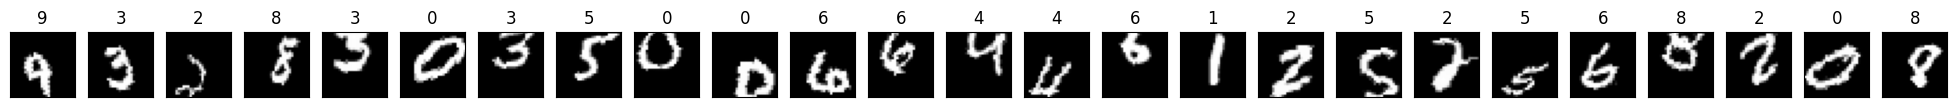

In [5]:
# prompt: show 25 img from train_loader

import matplotlib.pyplot as plt
import numpy as np
train_loader = get_train_loader()
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(25):
  ax = fig.add_subplot(1, 25, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  # print out the correct label for each image
  # .item() gets the value contained in a Tensor
  ax.set_title(str(labels[idx].item()))


In [6]:
# prompt: get data shape

train_loader = get_train_loader()
test_loader = get_test_loader()

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)


torch.Size([64, 1, 28, 28])
torch.Size([64])


## Model

In [7]:
class STN(nn.Module):
  def __init__(self):
      super(STN, self).__init__()
      self.conv1 = nn.Conv2d(1, 10, kernel_size=7)
      self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
      self.fc1 = nn.Linear(20 * 3 * 3, 32)
      self.fc2 = nn.Linear(32, 3 * 2)

      self.fc2.weight.data.zero_()
      self.fc2.bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

  def stn(self, x):
      # (batch_size, 1, 28, 28)
      xs = self.conv1(x)  # 10, 22, 22
      xs = F.max_pool2d(xs, 2)  # 10, 11, 11
      xs = F.relu(xs)
      xs = self.conv2(xs)  # 20, 7, 7
      xs = F.max_pool2d(xs, 2)  # 20, 3, 3
      xs = F.relu(xs)

      xs = xs.view(-1, 20 * 3 * 3)
      xs = F.relu(self.fc1(xs))
      theta = self.fc2(xs)  # 6
      theta = theta.view(-1, 2, 3)

      grid = F.affine_grid(theta, x.size())
      x = F.grid_sample(x, grid)
      return x

  def forward(self, x):
      return self.stn(x)


In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.stn = STN()
    self.fc1 = nn.Linear(20 * 4 * 4, 32)
    self.fc2 = nn.Linear(32, 10)

  def forward(self, x):
    x = self.stn(x)
    x = self.conv1(x)  # (1, 10, 24, 24)
    x = F.max_pool2d(x, 2)  # (1, 10, 12, 12)
    x = F.relu(x)
    x = self.conv2(x)  # (1, 20, 8, 8)
    x = self.conv2_drop(x)
    x = F.max_pool2d(x, 2) # (1, 20, 4, 4)
    x = F.relu(x)
    x = x.view(-1, 20 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)


In [9]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.stn = STN()
    self.fc1 = nn.Linear(20 * 4 * 4, 32)
    self.fc2 = nn.Linear(32, 10)

  def forward(self, x):
    x = self.conv1(x)  # (1, 10, 24, 24)
    x = F.max_pool2d(x, 2)  # (1, 10, 12, 12)
    x = F.relu(x)
    x = self.conv2(x)  # (1, 20, 8, 8)
    x = self.conv2_drop(x)
    x = F.max_pool2d(x, 2) # (1, 20, 4, 4)
    x = F.relu(x)
    x = x.view(-1, 20 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

## Train

In [10]:
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 500 == 0:
      print(f"Train Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] ({100. * batch_idx / len(train_loader)})\tLoss: {loss.item()}")

def test(model, device, test_loader):
  with torch.no_grad():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum', size_average=False).item()
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print(f"Test set: Average loss: {test_loss}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset)})")
  return 100. * correct / len(test_loader.dataset)


## Experiment

EPOCH

| Epoch | acc | opt | lr |
| ----- | ---- | ---- | ---- |
| 10 | 10% | SGD | 0.01 |
| 10 | 98.97% | SGD | 0.001|


## Train Net with STN



In [11]:
acc_list1 = []
df_acc = pd.DataFrame(columns=['epoch', 'acc'])
train_loader = get_train_loader()
test_loader = get_test_loader()

In [ ]:
model_1 = Net().to('cuda')
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001)
EPOCH = 50
for epoch in range(1, EPOCH + 1):
  train(model_1, 'cuda', train_loader, optimizer, epoch)
  acc = test(model_1, 'cuda', test_loader)
  acc_list1.append(acc)
  torch.save(model_1.state_dict(), f"/content/drive/MyDrive/work/STN/models/w_STN/50 Epoch/{epoch}.pth")
df_acc = pd.concat([df_acc, pd.DataFrame({'epoch': range(1, EPOCH + 1), 'acc': acc_list1})])
df_acc

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4434: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4373: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch 1 [0/60000] (0.0)	Loss: 2.3281450271606445
Train Epoch 1 [32000/60000] (53.304904051172706)	Loss: 2.2891368865966797


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Average loss: 2.291825910949707, Accuracy: 1401/10000 (14.01)
Train Epoch 2 [0/60000] (0.0)	Loss: 2.3024582862854004
Train Epoch 2 [32000/60000] (53.304904051172706)	Loss: 2.267810344696045
Test set: Average loss: 2.274334175491333, Accuracy: 2040/10000 (20.4)
Train Epoch 3 [0/60000] (0.0)	Loss: 2.2582294940948486
Train Epoch 3 [32000/60000] (53.304904051172706)	Loss: 2.2589008808135986
Test set: Average loss: 2.240193200683594, Accuracy: 2517/10000 (25.17)
Train Epoch 4 [0/60000] (0.0)	Loss: 2.2571184635162354
Train Epoch 4 [32000/60000] (53.304904051172706)	Loss: 2.2641758918762207
Test set: Average loss: 2.1645116065979004, Accuracy: 2814/10000 (28.14)
Train Epoch 5 [0/60000] (0.0)	Loss: 2.2320618629455566
Train Epoch 5 [32000/60000] (53.304904051172706)	Loss: 2.123486042022705
Test set: Average loss: 2.035341629600525, Accuracy: 3141/10000 (31.41)
Train Epoch 6 [0/60000] (0.0)	Loss: 1.9692535400390625
Train Epoch 6 [32000/60000] (53.304904051172706)	Loss: 1.88403916358947

<ipython-input-11-1b068d3acfc9>:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_acc = pd.concat([df_acc, pd.DataFrame({'epoch': range(1, EPOCH + 1), 'acc': acc_list1})])


,epoch,acc
0,1,14.01
1,2,20.40
2,3,25.17
3,4,28.14
4,5,31.41
5,6,46.76
6,7,62.87
7,8,72.38
8,9,77.32
9,10,75.42


## Train Net without STN

In [12]:
acc_list2 = []
df_acc = pd.DataFrame(columns=['epoch', 'acc'])
model_2 = Net2().to('cuda')
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.001)
EPOCH = 50
for epoch in range(1, EPOCH + 1):
  train(model_2, 'cuda', train_loader, optimizer, epoch)
  acc = test(model_2, 'cuda', test_loader)
  acc_list2.append(acc)
  torch.save(model_2.state_dict(), f"/content/drive/MyDrive/work/STN/models/wo_STN/50 Epoch/{epoch}.pth")
df_acc = pd.concat([df_acc, pd.DataFrame({'epoch': range(1, EPOCH + 1), 'acc': acc_list2})])
df_acc

Train Epoch 1 [0/60000] (0.0)	Loss: 2.347646951675415
Train Epoch 1 [32000/60000] (53.304904051172706)	Loss: 2.317969560623169


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Average loss: 2.294205447387695, Accuracy: 1573/10000 (15.73)
Train Epoch 2 [0/60000] (0.0)	Loss: 2.3045289516448975
Train Epoch 2 [32000/60000] (53.304904051172706)	Loss: 2.281641721725464
Test set: Average loss: 2.2821444580078123, Accuracy: 1778/10000 (17.78)
Train Epoch 3 [0/60000] (0.0)	Loss: 2.2936995029449463
Train Epoch 3 [32000/60000] (53.304904051172706)	Loss: 2.285454511642456
Test set: Average loss: 2.260402294921875, Accuracy: 2224/10000 (22.24)
Train Epoch 4 [0/60000] (0.0)	Loss: 2.2597200870513916
Train Epoch 4 [32000/60000] (53.304904051172706)	Loss: 2.233607053756714
Test set: Average loss: 2.2144393405914307, Accuracy: 2590/10000 (25.9)
Train Epoch 5 [0/60000] (0.0)	Loss: 2.2556376457214355
Train Epoch 5 [32000/60000] (53.304904051172706)	Loss: 2.206181526184082
Test set: Average loss: 2.1263301223754882, Accuracy: 2722/10000 (27.22)
Train Epoch 6 [0/60000] (0.0)	Loss: 2.1026883125305176
Train Epoch 6 [32000/60000] (53.304904051172706)	Loss: 2.18391871452331

<ipython-input-12-2fc4e8ab621a>:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_acc = pd.concat([df_acc, pd.DataFrame({'epoch': range(1, EPOCH + 1), 'acc': acc_list2})])


,epoch,acc
0,1,15.73
1,2,17.78
2,3,22.24
3,4,25.90
4,5,27.22
5,6,29.96
6,7,32.21
7,8,35.36
8,9,39.98
9,10,43.63


In [ ]:
# prompt: 展示經由STN重新調整後的圖片

import matplotlib.pyplot as plt
# 拿出第一張圖
image = images[0].unsqueeze(0).to('cuda')

# 拿出STN
stn = model_1.stn

# 讓圖片通過STN
stn_img = stn(image)

# 顯示圖片
plt.imshow(stn_img.cpu().detach().numpy().squeeze(), cmap='gray_r')


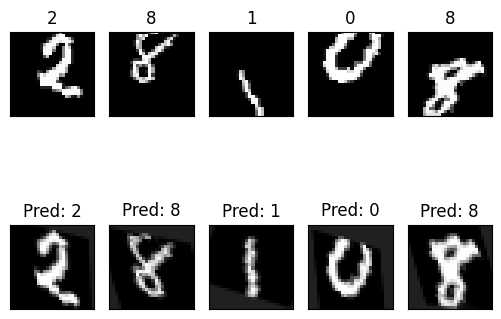

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 拿出一個 batch 的訓練圖片
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 將圖片轉為 numpy 陣列，準備顯示
images_np = images.numpy()

# 拿出 STN 和模型本體
stn = model_1.stn
predictor = model_1  # 假設 model_1 為整體模型，包含 STN 和後續分類層

# 創建 Figure
fig = plt.figure(figsize=(25, 4))

# 顯示 25 張圖片和經過 STN 調整後的圖片
for idx in np.arange(5):
    # 顯示原始圖片
    ax = fig.add_subplot(2, 25, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images_np[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

    # 將圖片轉為 Tensor 放入 GPU，並通過 STN
    stn_image = stn(images[idx].unsqueeze(0).to('cuda'))

    # 使用模型預測 STN 調整後的圖片
    with torch.no_grad():
        pred = predictor(stn_image)
        predicted_label = pred.argmax(dim=1).item()  # 假設為分類模型

    # 將調整後的圖片轉為 numpy，顯示於下方
    stn_image_np = stn_image.cpu().detach().numpy().squeeze()
    ax = fig.add_subplot(2, 25, idx + 1 + 25, xticks=[], yticks=[])
    ax.imshow(stn_image_np, cmap='gray')
    ax.set_title(f'Pred: {predicted_label}')

# 顯示圖片
plt.tight_layout()
plt.show()
